In [1]:

# handle categorical values through pd.get_dummies
# check with cross-validation


In [1]:
# try using proper train and test sets
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
import pandas as pd

challenge3_train = pd.read_csv('data/challenge3_train.csv')

# handle categorical values
# f12 is a difficult column, however all letter seem to be from the beginning of the alfabet
# as a result, we want to try just converting the letters into numbers corresponding to their number in the alphabet

char_conversion = {
    'A': '1',
    'B': '2',
    'C': '3',
    'D': '4',
    'E': '5',
    'F': '6',
    'G': '7',
    'H': '8',
    'I': '9'
}

# converts a given string to int, eg. b0ab8b134 -> 201282134
def convert_f12(s):
    if not isinstance(s, str):
        return s
    for c in s:
        if c.isalpha():
            s = s.replace(c, char_conversion[c.upper()])
    return int(s)

challenge3_train['f12'] = challenge3_train['f12'].apply(convert_f12)

# another difficult column is f28 because of its high cardinality, if we were to use get_dummies, there would be an insane amount of columns
# in this column we will use target encoding, which is mean encoding with features to prevent bias
encoder = TargetEncoder()
challenge3_train['f28'] = encoder.fit_transform(challenge3_train['f12'], challenge3_train['target'])

challenge3_train = pd.get_dummies(challenge3_train, columns=['f5', 'f15', 'f20'])

challenge3_train.columns

/home/mikkel/.cache/pypoetry/virtualenvs/project-J9--KlOd-py3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Index(['id', 'target', 'f0', 'f1', 'f2', 'f3', 'f4', 'f6', 'f7', 'f8', 'f9',
       'f10', 'f11', 'f12', 'f13', 'f14', 'f16', 'f17', 'f18', 'f19', 'f21',
       'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f5_F',
       'f5_M', 'f15_A', 'f15_B', 'f15_C', 'f20_A', 'f20_B', 'f20_C', 'f20_D',
       'f20_E', 'f20_F', 'f20_G', 'f20_H', 'f20_I', 'f20_J', 'f20_K', 'f20_L',
       'f20_M', 'f20_N', 'f20_O', 'f20_P', 'f20_Q', 'f20_R', 'f20_S', 'f20_T',
       'f20_U', 'f20_V', 'f20_W', 'f20_X', 'f20_Y', 'f20_Z'],
      dtype='object')

In [2]:
from sklearn.impute import SimpleImputer
# split train set into a train and test set
X = challenge3_train.drop(labels=['id', 'target'], axis=1)
y = challenge3_train.target

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.40)

# drops imputing as xgboost handles it
#my_imputer = SimpleImputer()
#train_X = my_imputer.fit_transform(train_X)
#test_X = my_imputer.transform(test_X)

In [3]:
%%time
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score

my_model = XGBRegressor()

# fit new df to model
my_model.fit(train_X, train_y, verbose=False)
# generate predictions
predictions = my_model.predict(test_X)
#calculate score
base_score = roc_auc_score(test_y, predictions)


CPU times: user 26.8 s, sys: 273 ms, total: 27.1 s
Wall time: 8.93 s


In [4]:
print(base_score)

0.9026095482926544


In [16]:
# As we can see, the score seems to be lower when replacing empty values with the most common value
# Lets try to remove one column at a time, make predictions and compare the scores
# Might seem stupid, but as the time for making the model and doing predictions is quite short, its fine

def calc_column_contributions(train_X, train_y, test_X, test_y):
    column_scores = {
        'column' : [],
        'score' : [],
        'diff': [],
    }

    column_scores = pd.DataFrame(column_scores, columns=['column', 'score', 'diff'])


    for col in train_X:
        # drop each column one by one
        train_df = train_X.drop(labels=[col], axis=1)
        test_df = test_X.drop(labels=[col], axis=1)
        # fit new df to model
        my_model.fit(train_df, train_y, verbose=False)
        # generate predictions
        predictions = my_model.predict(test_df)
        #calculate score
        score = roc_auc_score(test_y, predictions)

        diff = (base_score-score)

        column_scores = column_scores.append(pd.DataFrame([[col,score, diff]], columns=['column', 'score', 'diff']), ignore_index=True)
        
    # If a column received a negative diff, it means the model did better without it
    # Lets try one run using only the columns that achieved positive scores
    column_scores = column_scores.sort_values('score', ascending=True)
    column_scores.head()
    
    return column_scores
    

In [19]:
%%time
# If a column received a negative diff, it means the model did better without it
column_scores = calc_column_contributions(train_X, train_y, test_X, test_y)
column_scores.to_csv('column_scores.csv')

negative_cols = column_scores.loc[column_scores['diff']<0]
print(negative_cols)

   column     score      diff
2      f2  0.902652 -0.000009
21    f24  0.902672 -0.000029
55  f20_W  0.902677 -0.000033
45  f20_M  0.902683 -0.000039
51  f20_S  0.902726 -0.000083
39  f20_G  0.902733 -0.000089
41  f20_I  0.902777 -0.000134
43  f20_K  0.902834 -0.000190
42  f20_J  0.902871 -0.000228
27    f30  0.902947 -0.000304
53  f20_U  0.902970 -0.000327
58  f20_Z  0.903047 -0.000404
10    f11  0.903182 -0.000538
46  f20_N  0.903231 -0.000588
13    f14  0.903245 -0.000601
40  f20_H  0.903336 -0.000692
36  f20_D  0.903411 -0.000767
34  f20_B  0.903427 -0.000784
24    f27  0.903438 -0.000794
47  f20_O  0.903483 -0.000840
50  f20_R  0.903503 -0.000860
7      f8  0.903577 -0.000933
54  f20_V  0.903855 -0.001211
19    f22  0.904674 -0.002031
26    f29  0.904768 -0.002125
CPU times: user 23min 10s, sys: 3.02 s, total: 23min 13s
Wall time: 6min 26s


In [25]:
%%time
# Lets try dropping all negative columns
negative_col_names = negative_cols['column']

train_X_tuned = train_X.drop(labels=negative_col_names, axis=1)
test_X_tuned = test_X.drop(labels=negative_col_names, axis=1)

my_model = XGBRegressor()

# fit new df to model
my_model.fit(train_X_tuned, train_y, verbose=False)
# generate predictions
predictions = my_model.predict(test_X_tuned)
#calculate score
tuned_score = roc_auc_score(test_y, predictions)
print(tuned_score)


0.9021366572804613
CPU times: user 15.8 s, sys: 48.1 ms, total: 15.9 s
Wall time: 4.42 s


In [19]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def print_roc_curve(test_y, predictions):
    fpr, tpr, _ = roc_curve(test_y, predictions)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

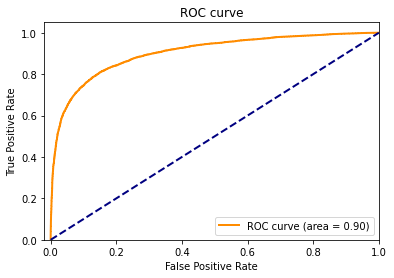

In [20]:
print_roc_curve(test_y, predictions)

In [22]:
%%time 
# now lets try tuning xgboost by letting it stop learning when the validation score stops improving, 
# and letting it cycle through the learning process until it does so

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# fit new df to model
my_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)
# generate predictions
predictions = my_model.predict(test_X)
#calculate score
tuned_score = roc_auc_score(test_y, predictions)
print(tuned_score)

0.9104458958086035
CPU times: user 49.3 s, sys: 397 ms, total: 49.7 s
Wall time: 15.7 s


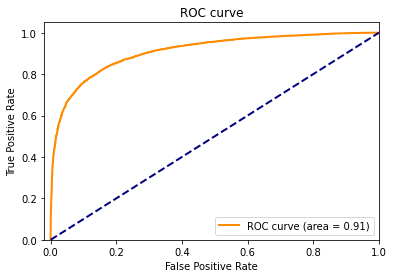

In [23]:
# we might have overfitted the model, and as a result we need to do cross validation
# lets plot the roc curve again
print_roc_curve(test_y, predictions)

In [1]:
# lets try another classification algorithm: OneVsRestClassifier
# DONT RUN THIS, IT WILL NEVER STOP
'''
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.impute import SimpleImputer

# we will have to do imputation:
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
onevrest_score = classifier.fit(train_X, train_y).decision_function(test_X)
'''

"\nfrom sklearn.multiclass import OneVsRestClassifier\nfrom sklearn import svm\nfrom sklearn.impute import SimpleImputer\n\n# we will have to do imputation:\nmy_imputer = SimpleImputer()\ntrain_X = my_imputer.fit_transform(train_X)\ntest_X = my_imputer.transform(test_X)\n\nclassifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))\nonevrest_score = classifier.fit(train_X, train_y).decision_function(test_X)\n"